# 1. Neural Network Warm-up Problem

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import math
import collections
import tensorflow as tf
import keras.backend as K
import seaborn as sns
from keras.datasets import mnist
from matplotlib.colors import ListedColormap
from keras.models import Model, Sequential, load_model
from keras.metrics import categorical_accuracy
from keras.layers import Input, Flatten, add
from keras.layers import Conv2D, Dense, Activation
from keras.layers import Dropout, BatchNormalization, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import regularizers
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.image as mpimg
import os
from PIL import Image

## a. Generate 500 samples 

In [252]:
def assign_label(X):
    
    y = None
    x1 = X[0, 0]; x2 = X[0, 1]

    if ((abs(x1) + abs(x2)) > 0.4) and ((abs(x1) + abs(x2)) < 0.7):
        y = 0

    elif (math.sqrt(x1**2 + x2**2) < 0.3):
        y = 1

    elif (math.sin(10.0*(x2*2)) < 0):
        y = 2

    elif (math.sin(5.0*(x1*2)) > 0):
        y = 3
    else:

        y = None

    return y

def gen_data(train_len,valid_len,test_len):
    
    num_samples = train_len + valid_len + test_len
    Y = []
    X = []
    i = 0
    
    while (i < num_samples):
    
    
        data = np.random.uniform(-1,1,(1,2))
        y = assign_label(data)
        
        while (y == None):
            
            #print('y is None')
            data = np.random.uniform(-1,1,(1,2))
            y = assign_label(data)
        
        i = i + 1
        X.append(data)
        Y.append(y)
    
    
    return X, Y
    

train_len = 500; valid_len = 500; test_len = 1000    
X,y = gen_data(train_len,valid_len,test_len)
y = np.array(y)
X = np.reshape(np.array(X), (len(X), 2))

#Conver to one-hot
y_cat = to_categorical(y, num_classes=4)

X_train = X[0:train_len,:]
X_valid = X[train_len:train_len+valid_len,:]
X_test = X[train_len+valid_len:,:]



y_train =  y_cat[0:train_len]
y_valid = y_cat[train_len:train_len+valid_len]
y_test = y_cat[train_len+valid_len:]

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)


(500, 2) (500, 2) (1000, 2)
(500, 4) (500, 4) (1000, 4)
Counter({2: 216, 3: 119, 0: 116, 1: 49})


## Relative Frequency 

Counter({2: 216, 3: 119, 0: 116, 1: 49})


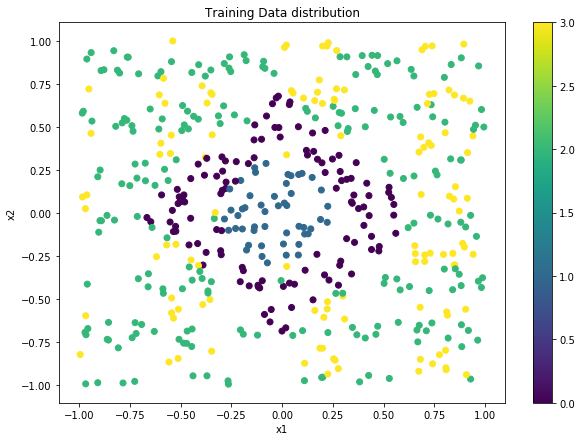

In [274]:
rel_freq = collections.Counter(y[0:train_len])
print(rel_freq)

#y__test = np.argmax(y_test, axis = 1)
colors = ['red','green','blue','purple']

fig, ax = plt.subplots(figsize= (10,7))
im = plt.scatter(X_train[:,0], X_train[:,1], c=y[0:500], cmap='viridis')
plt.title('Training Data distribution')
plt.xlabel('x1')
plt.ylabel('x2')
fig.colorbar(im, ax=ax)
plt.show()

# b. Neural Network

In [291]:
#Create NN topology

input_shape = X_train.shape[1]
print(input_shape)

model = Sequential()
model.add(Dense(60, input_dim= input_shape, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

# Compile model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2


In [292]:
history = model.fit(X_train, y_train, epochs=500,batch_size = None, validation_data= (X_valid, y_valid), verbose=0)

print('Training Accuracy: ', history.history['acc'][-1])
print('Validation Accuracy: ', history.history['val_acc'][-1])

Training Accuracy:  0.7659999995231629
Validation Accuracy:  0.7240000004768372


In [293]:
results = model.evaluate(X_valid, y_valid)
print('Validation Accuracy: ', results[1])

500/500 [==============================] - 0s 114us/step
Validation Accuracy:  0.7240000004768372


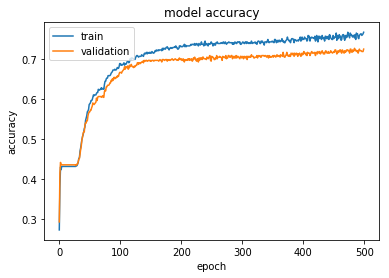

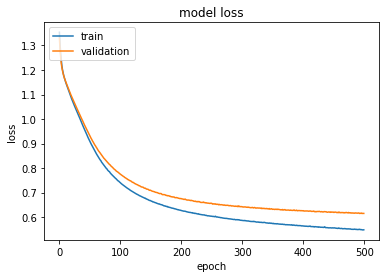

In [294]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# c. Run on test set

In [314]:
test_results = model.evaluate(X_test,y_test)
print('Test Accuracy: ', test_results[1]*100)

1000/1000 [==============================] - 0s 114us/step
Test Accuracy:  75.0


# d. Plotting the true vs. predicted labels

(1000,)


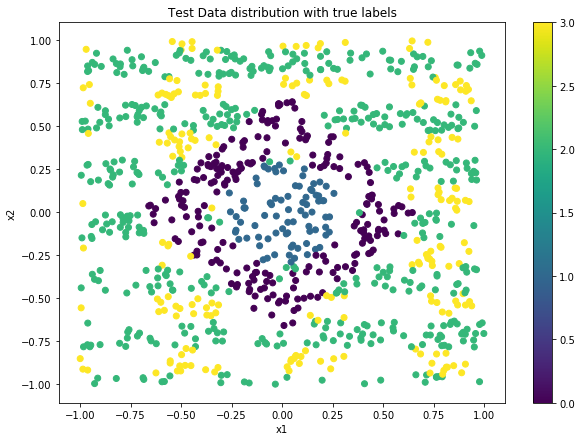

In [338]:
y_true = np.argmax(y_cat[1000:,:], axis = 1)
print(y_true.shape)
fig, ax = plt.subplots(figsize= (10,7))
im = plt.scatter(X_test[:,0], X_test[:,1], c=y_true, cmap='viridis')
plt.title('Test Data distribution with true labels')
plt.xlabel('x1')
plt.ylabel('x2')
fig.colorbar(im, ax=ax)
plt.show()



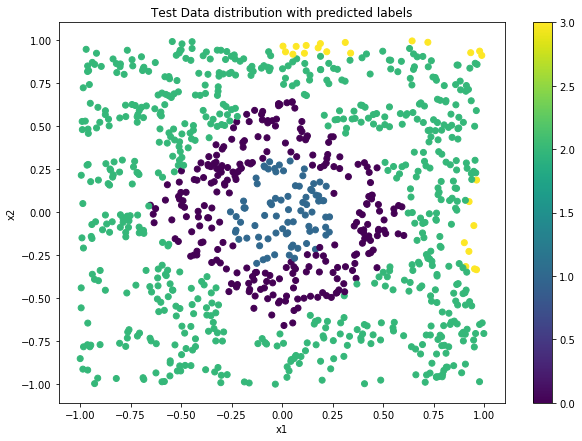

In [342]:
y__test = np.argmax(model.predict(X_test), axis = 1)


fig2, ax2 = plt.subplots(figsize= (10,7))
im2 = plt.scatter(X_test[:,0], X_test[:,1], c=y__test, cmap='viridis')
plt.title('Test Data distribution with predicted labels')
plt.xlabel('x1')
plt.ylabel('x2')
fig.colorbar(im2, ax=ax2)
plt.show()


In [344]:
print(accuracy_score(y_true,y__test))

0.75


# 2. Autoencoder

## b. Load Images 

In [ ]:
def LoadDir(dirname):
    imgs = []
    for imgname in os.listdir(dirname):
        img = Image.open(os.path.join(dirname, imgname))
        img = img.convert('LA')  # conver to grayscale
        img = img.resize([20, 20])
        img = np.squeeze(np.array(img)[:, :, 0])
        imgs.append(img)
    return np.array(imgs)

train_imgs = LoadDir('galaxy/train')
print (train_imgs.shape)
val_imgs = LoadDir('galaxy/val')
print (val_imgs.shape)
test_imgs = LoadDir('galaxy/test')
print (test_imgs.shape)

In [ ]:
np.savez('train_imgs', train_imgs=train_imgs)
np.savez('val_imgs', train_imgs= val_imgs)
np.savez('test_imgs', train_imgs=test_imgs)

## b. Load Data from npz

In [16]:
train = np.load('train_imgs.npz')
val = np.load('val_imgs.npz')
test= np.load('test_imgs.npz')

train = train['train_imgs']
val = val['train_imgs']
test= test['train_imgs']

print(train.shape)

(40872, 20, 20)


## Reshape

In [48]:
train = np.reshape(train, (train.shape[0], 400))
val = np.reshape(val, (val.shape[0], 400))
test = np.reshape(test, (test.shape[0], 400))
print(train.shape)
print(val.shape)
print(test.shape)

(40872, 400)
(10382, 400)
(10324, 400)


## c. PCA

In [83]:
# You will be comparing your autoencoder against principal component analysis (PCA),
# a linear dimensionality reduction technique. There's a function in sklearn that you can
# use { no need to implement it yourself. So, let's do this part first. Use PCA to reduce
# the images down to 25 dimensions and then reconstruct them again. Compute the
# reconstruction error in terms of the squared error per pixel on the validation and the
# test set.
  
nComp = 25

mu_train = np.mean(train, axis=0)
mu_val = np.mean(val, axis=0)
mu_test = np.mean(test, axis=0)

pca = PCA(n_components=nComp)

Xhat_train = np.dot(pca.fit_transform(train)[:,:nComp], pca.components_[:nComp,:])
Xhat_train += mu_train

Xhat_val = np.dot(pca.fit_transform(val)[:,:nComp], pca.components_[:nComp,:])
Xhat_val += mu_val

Xhat_test = np.dot(pca.fit_transform(test)[:,:nComp], pca.components_[:nComp,:])
Xhat_test += mu_test

In [84]:
#Reconstruction Error

recon_val = mean_squared_error(val, Xhat_val)
recon_test = mean_squared_error(test, Xhat_test)

print('Reconstruction error validation: %f, Reconstruction error test: %f'% (recon_val, recon_test))

Reconstruction error validation: 71.228754, Reconstruction error test: 71.428448


## d. Autoencoder 

In [89]:
encoding_dim = 25
train_norm = train.astype('float32') / 255.
val_norm = val.astype('float32') / 255.
test_norm = test.astype('float32') / 255.

input_shape = train_norm.shape[1:]

autoencoder = Sequential()
autoencoder.add(Dense(200,  activation='relu', input_shape=input_shape))
autoencoder.add(Dense(encoding_dim, activation='relu', name="bottleneck"))
autoencoder.add(Dense(200,  activation='relu'))
autoencoder.add(Dense(400, activation='sigmoid'))

encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)


#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

In [90]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(train_norm, train_norm, epochs=50, batch_size=128, shuffle=True, verbose=0, validation_data = (val_norm, val_norm))

In [81]:
#encoded_imgs = encoder.predict(val)
recon_imgs = autoencoder.predict(val_norm)
recon_imgs = recon_imgs*255.

In [82]:
recon_val = mean_squared_error(val, recon_imgs)
print(recon_val)

55.67932


## e. Compare PCA and Autoencoder 

Reconstruction MSE for Autoencoder test data: 59.153088
Reconstruction MSE for PCA test data: 71.428448


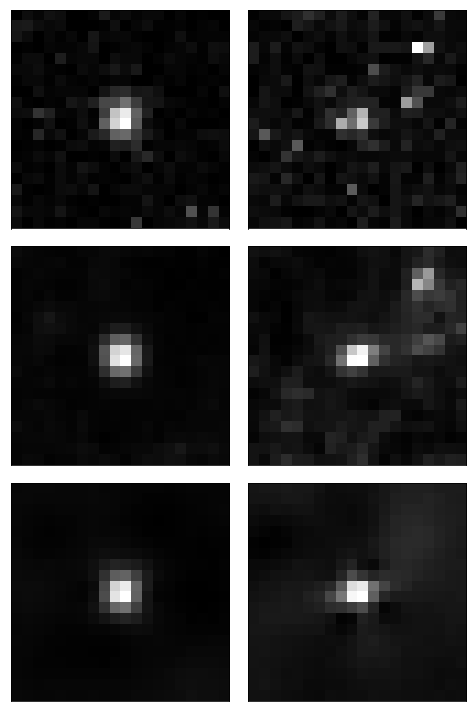

In [349]:
#Autoencoder Test

recon_imgs_test_auto = autoencoder.predict(test_norm)
recon_imgs_test = recon_imgs_test_auto*255.
recon_test_auto = mean_squared_error(test, recon_imgs_test)
print('Reconstruction MSE for Autoencoder test data: %f' %(recon_test_auto))

recon_test_PCA = mean_squared_error(test, Xhat_test)
print('Reconstruction MSE for PCA test data: %f' %(recon_test_PCA))

#Plot Reconstructions

toPlot = (test, recon_imgs_test, Xhat_test)

#print(toPlot[1][i,:])
fig = plt.figure(figsize=(10,10))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(3, 3,3*j+i+1)
        plt.imshow(toPlot[j][1000-i,:].reshape(20,20))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()

## f.  Image Comparison

1940
954
-323.8134436424446
395.98468365212796


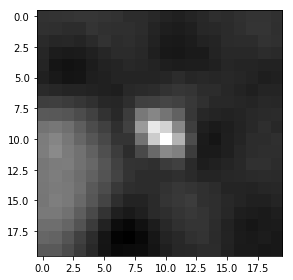

In [375]:
#recon_imgs_test_auto = autoencoder.predict(test_norm)
el_err_auto = (np.sum((test - recon_imgs_test_auto*255.)**2, axis=1)/400)
el_err_pca = (np.sum((test - Xhat_test)**2, axis=1)/400)

print(np.argmin((el_err_auto - el_err_pca)))
print(np.argmax(el_err_auto - el_err_pca))

print((el_err_auto - el_err_pca)[1940]) #PCA wins
print((el_err_auto - el_err_pca)[954]) #Autoencoder wins

toPlot = (test, recon_imgs_test, Xhat_test)


#ax = fig.add_subplot(3, 1,1*j+i+1)
plt.imshow(Xhat_test[1940,:].reshape(20,20))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()